# Medicaid Data by State from CMS (1997-2014)

In an attempt to develop a proxy for Medicaid program generosity (see **`mcaid_by_state`**), it became clear that NIPA data conflicted with other sources.  Specifically, some states had wildly different data from the information presented by [KFF](http://kff.org/medicaid/state-indicator/total-medicaid-spending/#), which is based on Form CMS-64 data reported by states to CMS.  To some extent, we have limited recourse.  Before 1997, NIPA is the only consolidated source of Medicaid spending by state.  However, CMS has made data available from 1997 on.

In this Notebook, we will liberate the data between 1997 and 2014 from the sadistic shackles that CMS has chosen to store it, otherwise known as Excel.

In [113]:
#Data Management
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from openpyxl import *

#Visualization
import seaborn as sb

%pylab inline

plt.rcParams['axes.edgecolor']='k'
plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.facecolor']=(1,1,1,0)
plt.rcParams['grid.color']='k'
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.linewidth']=0.3

pd.set_option('display.width',140)

Populating the interactive namespace from numpy and matplotlib


The [data in question](https://www.medicaid.gov/medicaid-chip-program-information/by-topics/financing-and-reimbursement/expenditure-reports-mbes-cbes.html) are housed in four workbooks with irregular temporal coverage and formatting.  The formatting in particular means we will not be able to rely on a general function to handle all of it.  However, we should be fairly consistent within the workbook, so some room for programmatic efficiency is available.

## 1997-2001

We can start by loading the first notebook and grabbing the sheet names.

In [2]:
#Establish data location
data_dir='O:/Analyst/Marvin/Medicaid/'

#Read in data
fmr97=load_workbook(data_dir+'FMR1997through2001.xlsx')

#Create container to hold sheet objects
fmr97_dict={}

#Capture sheet objects
for sheet in fmr97.get_sheet_names():
    fmr97_dict.update({int(sheet[-4:]):fmr97.get_sheet_by_name(sheet)})
    
fmr97_dict[1997]

<Worksheet "FMR1997">

Once we have a sheet, we can query its contents in a couple ways...

In [3]:
print fmr97_dict[1998]['A1'].value
print fmr97_dict[1998].cell(row=1,column=1).value

Medicaid Finanacial Management Report
Medicaid Finanacial Management Report


Visual inspection suggests that there are a few pieces of information we want to collect.

1. The state name;
2. Total Medicaid expenditure;
3. The federal share of Medicaid expenditure; and,
4. The state share of Medicaid expenditure.

Each observation in our final set will carry these pieces of information, in addition to the year (which is constant within sheet).  Total expenditure (and the shares) must be aggregated over two data within-state data points:

1. `Total Net Expenditures`
2. `C-Total Net`

To allocate these expenditures, we will rely on position.  The values of net expenditures that follow Alaska, but precede Alabama (presumably ordered by postal code) will be allocated to Alaska.  Therefore, we need a function that will identify a state name as the start of an observation, capture the cumulative expenditures as we move down through the rows, and then simultaneously close out that observation while opening a new observation upon encountering the next state name.

The `cell()` method enables us to iteratively run across the sheet via simple loops.  We can capture the start position of each observation, and then the positions of the relevant values for that observation.  Capturing the rows with the data is easy, because the tags don't change.  The states, on the other hand, are not marked by some common concept ID.  We need to test membership in a list of state names to identify them.  Let's grab that state info first...

In [4]:
#Read in mapping
st_map=pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')

#Convert to dict
st_dict=dict(zip(st_map['State'],st_map['Abbreviation']))

#Include DC
st_dict.update({'District of Columbia':'DC',
                'Dist. Of Col.':'DC',
                'DC':'DC'})

...and now we can define functions to capture state positions, state data, and a consolidated view of all relevant state data in a given sheet.

In [128]:
def get_state_pos_list(sheet,st_dict=st_dict):
    '''Function captures state positions in a given sheet of an active workbook'''
    #Create a container for state positions
    state_pos=[]
    #For each row...
    for i in range(int(sheet.max_row)):
        #...if the cell value is in the list of states...
        if sheet.cell(row=i+1,column=1).value in st_dict.keys():
            #...capture the position and the cell value
            state_pos.append((i+1,sheet.cell(row=i+1,column=1).value))
    return state_pos

def scan_col(sheet,col_num,val,row_0=1):
    '''Functions scans a given column for a value and returns the row location'''
    #Initialize row iterator
    row_i=row_0
    #Until we have encountered the value in the given column...
    while sheet.cell(row=row_i,column=col_num).value!=val and row_i<20000:
        #...move down the given column (via iteration)...
        row_i+=1
        #...if we do encounter the value...
        if sheet.cell(row=row_i,column=col_num).value==val:
            return row_i
        
def scan_row(sheet,row_num,val,col_0=1):
    '''Functions scans a given row for a value and returns the column location'''
    #Initialize column iterator
    col_i=col_0
    #Until we have encountered the value in the given column...
    while sheet.cell(row=row_num,column=col_i).value!=val and col_i<20000:
        #...move right across the given row (via iteration)...
        col_i+=1
        #...if we do encounter the value...
        if sheet.cell(row=row_num,column=col_i).value==val:
            return col_i

def get_data_columns(sheet,dlabs=['Total Computable','Federal Share','State Share']):
    '''Function returns dict with the locations of columns containing total, federal share, and state share data'''
    #Identify the first row with data labels
    lab_row=scan_col(sheet,1,'Service Category')
    #Create dict to hold column locations
    dcol1={}
    dcol2={}
    #For each label...
    for lab in dlabs:
        #...capture the column locations in the first bank...
        dcol1.update({lab:scan_row(sheet,lab_row,lab)})
    #Identify the right-most column
    new_start_col=max(np.array([dcol1[lab] for lab in dcol1.keys()]))+1
    #For each label...
    for lab in dlabs:
        #...capture the column locations in the second bank...
        dcol2.update({lab:scan_row(sheet,lab_row,lab,col_0=new_start_col)})
    return (dcol1,dcol2)

def get_data_rows(pos,sheet,exp_components,dcol_dict):
    '''Function returns dicts with the row locations for within state data'''
    #Identify label columns
    lab_row=scan_col(sheet,1,'Service Category')
    col1=1
    col2=scan_row(sheet,lab_row,'Service Category',col_0=col1+1)
    #Create dicts to hold row positions for the current state
    drow1={}
    drow2={}
    #For each component in the first bank...
    for component in exp_components[0]:
        #...capture the row position of that component
        drow1.update({component:scan_col(sheet,col1,component,row_0=pos[0])})
    #For each component in the second bank...
    for component in exp_components[1]:
        #...capture the row position of that component
        drow2.update({component:scan_col(sheet,col2,component,row_0=pos[0])})
    return (drow1,drow2)

def get_state_data(pos,sheet,exp_components,dlabs=['Total Computable','Federal Share','State Share']):
    '''Function returns DF containing the data for a single state in the current year'''
    #Capture the data column locations
    dcols=get_data_columns(sheet)
    #Capture the data row locations
    drows=get_data_rows(pos,sheet,exp_components,dcols)
#     print dcols
#     print drows
    #Create container to hold bank-specific DFs
    bank_dfs=[]
    #For each bank...
    for bank_i in range(2):
        #...create containers to hold component-specific subsets within bank...
        bank_subs=[]
        #...for each component...
        for component in exp_components[bank_i]:
            #...create a dict to hold the data...
            comp_dict={}
            #...for each label...
            for label in dlabs:
                #...capture the data...
                comp_dict.update({label:sheet.cell(row=drows[bank_i][component],
                                                   column=dcols[bank_i][label]).value})
            #...with the component data complete, convert to DF...
            comp_df=DataFrame(comp_dict,index=[component+' '+str(bank_i)])
            #...and throw it in bank_subs...
            bank_subs.append(comp_df)
        #...with all the component subsets in this bank in hand, concatenate...
        bank_sub_df=pd.concat(bank_subs)
        #...and throw it in bank_dfs...
        bank_dfs.append(bank_sub_df)
    #...concatenate both bank subset together
    state_df=pd.concat(bank_dfs)
    #Integrate the state name
    state_df['state']=pos[1]
    return state_df
    
    
# def get_state_data(pos,sheet,exp_components,dcol_dict):
#     '''Function captures data associated with a given state (defined by pos)'''
#     #Capture the line number in which the state data block starts
#     pos_i=pos[0]
#     #Create a container to hold data for each state-specific component
#     component_tmp=[]
#     #For each component...
#     for component in exp_components:
#         #...until we have encountered the component label in the data label column...
#         while sheet.cell(row=pos_i,column=1).value!=component and pos_i<20000:
#             #...move down the data label column (via iteration)...
#             pos_i+=1
#             #...if we do encounter the component label...
#             if sheet.cell(row=pos_i,column=1).value==component:
#                 #...capture the total, federal, and state data values in dict...
#                 row_data_tmp={}
#                 for label in dcol_dict.keys():
#                     row_data_tmp.update({label:sheet.cell(row=pos_i,column=dcol_dict[label]).value})
#                 #...convert to DF
#                 row_tmp=DataFrame(row_data_tmp,index=[component])
# #                 row_tmp=DataFrame({'total':sheet.cell(row=pos_i,column=tot_col).value,
# #                                    'fed_shr':sheet.cell(row=pos_i,column=fed_col).value,
# #                                    'st_shr':sheet.cell(row=pos_i,column=st_col).value},index=[component])
#                 #...and throw the DF in component_tmp...
#                 component_tmp.append(row_tmp)
#                 break
#     #Once all component data has been collected, concatenate to a single DF
#     component_df=pd.concat(component_tmp)
#     #Integrate the state name
#     component_df['state']=pos[1]
#     return component_df

# def get_sheet_data(yr,sheet,exp_components,dcol_dict,st_dict=st_dict):
def get_sheet_data(yr,sheet,exp_components,st_dict=st_dict):
    '''Function captures expenditure data for all states in the sheet'''
    #Capture state positions
    state_pos=get_state_pos_list(sheet)
    #Create container to hold data for all states
    state_data=[]
    #For each state...
    for pos in state_pos:
        #...throw state-specific data in state_data
#         state_data.append(get_state_data(pos,sheet,exp_components,dcol_dict))
        state_data.append(get_state_data(pos,sheet,exp_components))
    #Once the data for all states is collected, concatenate it all together        
    state_df=pd.concat(state_data)
    #Integrate the year
    state_df['year']=yr
    #Reset index and rename old index column
    state_df=state_df.reset_index().rename(columns={'index':'component'})
    #Set the index
    state_df.set_index(['year','state','component'],inplace=True)
    #Sort the index
    state_df.sortlevel(0,inplace=True)
    return state_df

Does it work?

In [129]:
#Define expenditure components
exp_components97=(['Total Net Expenditures','C-Total Net'],
                  ['Total Net Expenditures','Total'])

#Define data column locations
dcol_97={'Total Computable':2,
         'Federal Share':3,
         'State Share':4}

# get_sheet_data(1998,fmr97_dict[1998],exp_components97,dcol_97,st_dict)
get_sheet_data(1998,fmr97_dict[1998],exp_components97,st_dict)

Federal Share  State Share  Total Computable
year state         component                                                             
1998 Alabama       C-Total Net 0                   2189855       599057           2788912
                   Total 1                          243317        66562            309879
                   Total Net Expenditures 0     1612326171    711814765        2324140936
                   Total Net Expenditures 1       31069394     22588801          53658195
     Alaska        C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0      238787815    124133504         362921319
                   Total Net Expenditures 1       20364618     14279273          34643891
     Arizona       C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0     1241778897    619270188        1861049085
                   Total Net Expenditures 1       75176973     62856092         138033065
     Arkansas      C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0     1025895613    380353215        1406248828
                   Total Net Expenditures 1       51779665     34449438          86229103
     California    C-Total Net 0                    781733       405230           1186963
                   Total 1                         1204007       624123           1828130
                   Total Net Expenditures 0     9393343861   8938945937       18332289798
                   Total Net Expenditures 1      633262836    591495493        1224758329
     Colorado      C-Total Net 0                         0            0                 0
                   Total 1                          987999       500402           1488401
                   Total Net Expenditures 0      835160724    769282517        1604443241
                   Total Net Expenditures 1       37592566     27346024          64938590
     Connecticut   C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0     1416466977   1415206783        2831673760
                   Total Net Expenditures 1       54314806     39917310          94232116
     Delaware      C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
...                                                    ...          ...               ...
     Texas         Total Net Expenditures 0     6102963275   3672236434        9775199709
                   Total Net Expenditures 1      319762855    257189385         576952240
     Utah          C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0      491962041    184971324         676933365
                   Total Net Expenditures 1       29728110     22926195          52654305
     Vermont       C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0      247666302    149679386         397345688
                   Total Net Expenditures 1       18740017     14162341          32902358
     Virginia      C-Total Net 0                         0            0                 0
                   Total 1                               0            0              

Indeed it does, and note that the data from each bank is labeled as such to help differentiate across labels.  The left bank has a 0 appended, while the right has 1 appended.  Speaking of which, we are fairly confident we will have cause to exclude the administrative cost information from the set, which we can execute with slices.

In [130]:
tmp_sheet.loc[(slice(None),slice(None),tmp_comps_desired),:]

Federal Share  State Share  Total Computable
year state         component                                                             
1998 Alabama       C-Total Net 0                   2189855       599057           2788912
                   Total 1                          243317        66562            309879
                   Total Net Expenditures 0     1612326171    711814765        2324140936
     Alaska        C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0      238787815    124133504         362921319
     Arizona       C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0     1241778897    619270188        1861049085
     Arkansas      C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0     1025895613    380353215        1406248828
     California    C-Total Net 0                    781733       405230           1186963
                   Total 1                         1204007       624123           1828130
                   Total Net Expenditures 0     9393343861   8938945937       18332289798
     Colorado      C-Total Net 0                         0            0                 0
                   Total 1                          987999       500402           1488401
                   Total Net Expenditures 0      835160724    769282517        1604443241
     Connecticut   C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0     1416466977   1415206783        2831673760
     Delaware      C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0      207937634    206232532         414170166
     Dist. Of Col. C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0      555552960    309969414         865522374
     Florida       C-Total Net 0                   4450754      2003357           6454111
                   Total 1                         1905533       857712           2763245
                   Total Net Expenditures 0     3547675700   2816629015        6364304715
...                                                    ...          ...               ...
     South Dakota  C-Total Net 0                     46829        13650             60479
                   Total 1                            5203         1517              6720
                   Total Net Expenditures 0      248350180    107215805         355565985
     Tennessee     C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0     2521519369   1451809971        3973329340
     Texas         C-Total Net 0                   1275400       457482           1732882
                   Total 1                           33301        11945             45246
                   Total Net Expenditures 0     6102963275   3672236434        9775199709
     Utah          C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0      491962041    184971324         67693

It at least appears to do so (and spot checks are consistent).  Let's capture all of the data from the current workbook.

In [131]:
def get_wb_data(wb_dict,exp_components,st_dict=st_dict):
    '''Function returns Medicaid expenditure by state from all years (sheets) in workbook'''
    #Create container to hold data from each sheet
    wb_list=[]
    #For each year...
    for yr in wb_dict.keys():
        #...identify data columns...
#         dcol_dict=get_data_columns(wb_dict[yr])
        #...throw the sheet-specific data in fmr97_list
#         wb_list.append(get_sheet_data(yr,wb_dict[yr],exp_components,dcol_dict,st_dict))
        wb_list.append(get_sheet_data(yr,wb_dict[yr],exp_components,st_dict))
    #Concatenate into a single DF
    wb_df=pd.concat(wb_list)
    #Sort index
    wb_df.sortlevel(0,inplace=True)
    return wb_df

#Capture data for 1997-2001
fmr97_full=get_wb_data(fmr97_dict,exp_components97,dcol_97)
print fmr97_full
#Exclude administrative data
non_admin_comps=[comp for comp in fmr97_full.index.get_level_values(level='component') if comp != 'Total Net Expenditures 1']
fmr97_less_admin=fmr97_full.loc[(slice(None),slice(None),non_admin_comps),:]

#Sum over components
fmr97_df=fmr97_full.groupby(level=['year','state']).sum()

fmr97_df

                                             Federal Share  State Share  Total Computable
year state         component                                                             
1997 Alabama       C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0     1528097087    667262659        2195359746
                   Total Net Expenditures 1       27082231     18986797          46069028
     Alaska        C-Total Net 0                         0            0                 0
                   Total 1                               0            0                 0
                   Total Net Expenditures 0      202497708    157616505         360114213
                   Total Net Expenditures 1       20736445     15186633          35923078
     Arizona       C-Total Net 0                         0            0                 0
          

Federal Share  State Share  Total Computable
year state                                                       
1997 Alabama            1555179318    686249456        2241428774
     Alaska              223234153    172803138         396037291
     Arizona            1238187276    638120352        1876307628
     Arkansas           1002154961    378476793        1380631754
     California         8480765151   8368142378       16848907529
     Colorado            829264836    743616170        1572881006
     Connecticut        1391631785   1386834937        2778466722
     Delaware            219934541    211664472         431599013
     Dist. Of Col.       440683716    434835797         875519513
     Florida            3615568320   2866165198        6481733518
     Georgia            2250117244   1414579858        3664697102
     Hawaii              291599543    288663217         580262760
     Idaho               302523760    146777631         449301391
     Illinois           3546779998   3485203931        7031983929
     Indiana            1579160208    984986673        2564146881
     Iowa                798420012    471276583        1269696595
     Kansas              623254159    438514083        1061768242
     Kentucky           1818784234    790835186        2609619420
     Louisiana          2465574840    651512312        3117087152
     Maine               694045310    398880179        1092925489
     Maryland           1451376696   1432705153        2884081849
     Massachusetts      2547304603   2518570689        5065875292
     Michigan           3397271358   2740455674        6137727032
     Minnesota          1547364614   1330023509        2877388123
     Mississippi        1324470747    399735640        1724206387
     Missouri           1922779352   1289033388        3211812740
     Montana             276909447    122154750         399064197
     Nebraska            465459497    321140050         786599547
     Nevada              253551581    247293036         500844617
     New Hampshire       381184191    376600141         757784332
...                            ...          ...               ...
2001 Massachusetts      3555467087   3457943845        7013410932
     Michigan           4466716449   3478847929        7945564378
     Minnesota          2101936628   1976011171        4077947799
     Mississippi        1970655691    604390622        2575046313
     Missouri           3090632961   1944608427        5035241388
     Montana             394234271    145106440         539340711
     Nebraska            767133923    498253049        1265386972
     Nevada              379312107    358539142         737851249
     New Hampshire       468830797    457979387         926810184
     New Jersey         3837066189   3722655954        7559722143
     New Mexico         1150080046    404314522        1554394568
     New York          16664505583  16331911840       32996417423
     North Carolina     4074086914   2451439940        6525526854
     North Dakota        302657991    130166155         432824146
     Ohio               5312053200   3685494596        8997547796
     Oklahoma           1576033170    626989870        2203023040
     Oregon             1744374465   1153918052        2898292517
     Pennsylvania       6243544943   5276809253       11520354196
     Rhode Island        696235253    586135932        1282371185
     South Carolina     2242240440    939181924        3181422364
     South Dakota        339734133    144232299         483966432
     Tennessee          3618461090   2067034495        5685495585
     Texas              7656123202   4948817383       12604940585
     Utah                661740066    271661117         933401183
     Vermont             406327068    244524677         650851745
     Virginia           1730556656   1514621667        3245178323
     Washington         2441857819   2336327154        4778184973
     West Virginia      1227712279    417003991        164471

## 2002-2011

Let's move on to the next workbook, and capture the sheets.

In [132]:
#Read in data
fmr02=load_workbook(data_dir+'NetExpenditure02through11.xlsx')

#Create container to hold sheet objects
fmr02_dict={}

#Capture sheet objects
for sheet in fmr02.get_sheet_names():
    fmr02_dict.update({int(sheet[-4:]):fmr02.get_sheet_by_name(sheet)})
    
fmr02_dict

{2002: <Worksheet "2002">,
 2003: <Worksheet "2003">,
 2004: <Worksheet "2004">,
 2005: <Worksheet "2005">,
 2006: <Worksheet "2006">,
 2007: <Worksheet "2007">,
 2008: <Worksheet "2008">,
 2009: <Worksheet "2009">,
 2010: <Worksheet "2010">,
 2011: <Worksheet "2011">}

A wrinkle has arisen with this batch of sheets.  The columns holding the total, federal share, and state share data values are inconsistent.  The first implication was a need to go back and retrofit our earlier functions to allow for variation in the data column locations.  The second is a need to now define a function that can locate which columns hold the data (also done retroactively).

In [133]:
#Define list of components
exp_components02=(['Total Net Expenditures','C-Total Net','T-Total Net Expenditures'],
                  ['Total Net Expenditures','Total'])

#Capture data for 2002-2011
fmr02_full=get_wb_data(fmr02_dict,exp_components02)

#Sum over components
fmr02_df=fmr02_full.groupby(level=['year','state']).sum()

fmr02_df

Federal Share  State Share  Total Computable
year state                                                       
2002 Alabama            2297737063    966127562        3263864625
     Alaska              493444784    275797937         769242721
     Arizona            2617151961   1306880556        3924032517
     Arkansas           1695438788    647760749        2343199537
     California        15577783304  14166555372       29744338676
     Colorado           1249043996   1211589285        2460633281
     Connecticut        1837066971   1789254210        3626321181
     Delaware            357022668    335216555         692239223
     Dist. Of Col.       756204379    332504038        1088708417
     Florida            6144153281   4644215115       10788368396
     Georgia            3970577178   2721804992        6692382170
     Hawaii              459473574    350622918         810096492
     Idaho               603733211    250467264         854200475
     Illinois           4836998123   4728626310        9565624433
     Indiana            2929361587   1782495060        4711856647
     Iowa               1695386594    998386278        2693772872
     Kansas             1211654017    794643239        2006297256
     Kentucky           2766506838   1188240555        3954747393
     Louisiana          3594531383   1510035553        5104566936
     Maine              1008525284    504655131        1513180415
     Maryland           2084272805   1987073505        4071346310
     Massachusetts      4281165550   4191737246        8472902796
     Michigan           4184542770   3270862848        7455405618
     Minnesota          2415942432   2345796109        4761738541
     Mississippi        2313497345    734936808        3048434153
     Missouri           3458554090   2203179055        5661733145
     Montana             450141316    163137588         613278904
     Nebraska            859218399    578525036        1437743435
     Nevada              460135031    435625584         895760615
     New Hampshire       547822500    532862155        1080684655
...                            ...          ...               ...
2011 Massachusetts      8067942705   6029321963       14097264668
     Michigan           8977453807   3701296880       12678750687
     Minnesota          4900326645   3798910681        8699237326
     Mississippi        3790654314    955582354        4746236668
     Missouri           5815110623   2627704745        8442815368
     Montana             787094733    281232861        1068327594
     Nebraska           1152267459    651188122        1803455581
     Nevada             1001675554    692380696        1694056250
     New Hampshire       818415932    621640419        1440056351
     New Jersey         6797851139   5228963821       12026814960
     New Mexico         2763974898    852456886        3616431784
     New York          30731457532  23096796394       53828253926
     North Carolina     7914849876   3412363228       11327213104
     North Dakota        505882122    261889113         767771235
     Ohio              11321993696   5086446074       16408439770
     Oklahoma           3189839789   1217600230        4407440019
     Oregon             3293073342   1546337623        4839410965
     Pennsylvania      13510769703   8255140858       21765910561
     Rhode Island       1315879226    896294953        2212174179
     South Carolina     3884826568   1322832013        5207658581
     South Dakota        559293135    251267009         810560144
     Tennessee          6082043235   2510612789        8592656024
     Texas             20117079649  10156407299       30273486948
     Utah               1445866550    472216383        1918082933
     Vermont             852702226    451114644        1303816870
     Virginia           4225811325   3169636026        7395447351
     Washington         4618745758   3365338726        7984084484
     West Virginia      2273204580    641945100        291514

In [134]:
for yr in range(2002,2012):
    print get_data_columns(fmr02_dict[yr])

({'State Share': 4, 'Total Computable': 2, 'Federal Share': 3}, {'State Share': 8, 'Total Computable': 6, 'Federal Share': 7})
({'State Share': 4, 'Total Computable': 2, 'Federal Share': 3}, {'State Share': 8, 'Total Computable': 6, 'Federal Share': 7})
({'State Share': 4, 'Total Computable': 2, 'Federal Share': 3}, {'State Share': 8, 'Total Computable': 6, 'Federal Share': 7})
({'State Share': 4, 'Total Computable': 2, 'Federal Share': 3}, {'State Share': 8, 'Total Computable': 6, 'Federal Share': 7})
({'State Share': 4, 'Total Computable': 2, 'Federal Share': 3}, {'State Share': 8, 'Total Computable': 6, 'Federal Share': 7})
({'State Share': 4, 'Total Computable': 2, 'Federal Share': 3}, {'State Share': 8, 'Total Computable': 6, 'Federal Share': 7})
({'State Share': 4, 'Total Computable': 2, 'Federal Share': 3}, {'State Share': 8, 'Total Computable': 6, 'Federal Share': 7})
({'State Share': 6, 'Total Computable': 2, 'Federal Share': 3}, {'State Share': 10, 'Total Computable': 8, 'Fed

## Consolidation

Now we can combine all years between 1997-2011.

In [143]:
#Concatenate
fmr_full=pd.concat([fmr97_full,fmr02_full])

#Capture administrative component
fmr_admin=fmr_full.xs('Total Net Expenditures 1',level='component')

#Capture all but administrative component
fmr_non_admin=fmr_full.loc[(slice(None),slice(None),tmp_comps_desired),:]

#Sum non-admin over components
fmr=fmr_non_admin.groupby(level=['year','state']).sum()

print '***ADMIN***\n',fmr_admin.head(10)
print '\n***NON-ADMIN***\n',fmr.head(10)

***ADMIN***
                    Federal Share  State Share  Total Computable
year state                                                      
1997 Alabama             27082231     18986797          46069028
     Alaska              20736445     15186633          35923078
     Arizona             64076820     53596917         117673737
     Arkansas            38908941     28174151          67083092
     California        -166566349   -196977821        -363544170
     Colorado            36417095     23459493          59876588
     Connecticut         34640982     31373751          66014733
     Delaware            15494861      9525188          25020049
     Dist. Of Col.       20401879     15519667          35921546
     Florida            112509619     99116330         211625949

***NON-ADMIN***
                    Federal Share  State Share  Total Computable
year state                                                      
1997 Alabama           1528097087    667262659        2195359

We are concerned with establishing state-level generosity, and it is not clear a priori whether or not the federal share is influenced by state generosity.  Therefore, to know which number to use, we need to know how the federal share is calculated.  The federal share is based upon the [Federal Medical Assistance Percentage](https://aspe.hhs.gov/federal-medical-assistance-percentages-or-federal-financial-participation-state-assistance-expenditures), which is used to determine the matching funds provided by the federal government to states for certain social and medical programs.  Medicaid is one of those programs.

The formulas for Medicaid and CHIP are defined in Sections 1905(b) and 2105(b), respectively, of the Social Security Act.  The FMAP applies to Medicaid funding:

$$FMAP_{\text{intermediate}} = 1.00 - 0.45(\frac{pcinc_{\text{St}}^2}{pcinc_{\text{US}}^2})$$

$$FMAP_{\text{final}}=\text{max}(\text{min}(FMAP_{\text{intermediate}},0.83),0.50)$$

For islands and territories, $FMAP_{\text{final}}=55\%$, while for DC $FMAP_{\text{final}}=70\%$.  These rates do not incorporate ACA expansions, in which $FMAP_{\text{final}}=100\%$ for the expanded population in participating states (starting after our data in FY14).

The "enhanced FMAP", which applies to CHIP funding, is based upon the FMAP.

$$eFMAP_{\text{intermediate}} = 0.30*(1.00 - FMAP_{\text{final}})$$

$$eFMAP_{\text{final}}=\text{max}(eFMAP_{\text{intermediate}},0.85)$$

The formulae are both driven by per capita income at the state and national levels, as well as the volume of state spending (because they are matching funds).  In fact, the federal share controls somewhat for disparate ability to finance, while also speaking to financing effort.  Therefore, the appropriate number to use for generosity is the total computable amount.

We can actually consolidate the regular (a.k.a. non-admin) and admin totals to see if a relationship between them exists.

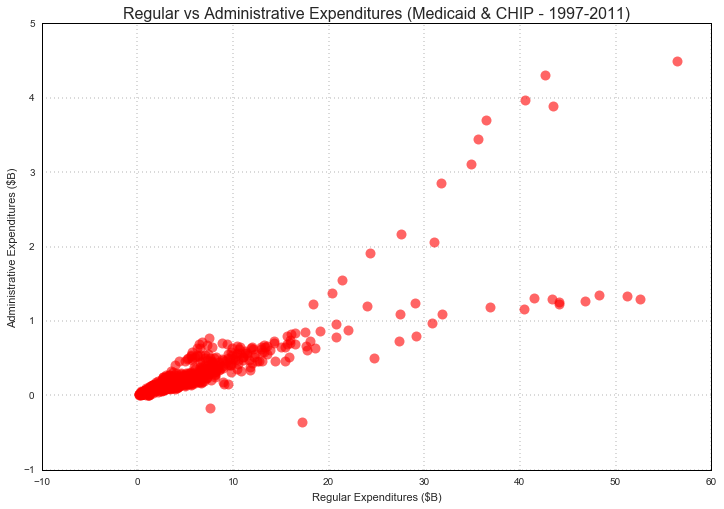

In [157]:
#Capture final expenditure DF
fmr_tot=DataFrame(fmr['Total Computable']).join(DataFrame(fmr_admin['Total Computable']),rsuffix='1')
fmr_tot.columns=['regular','admin']

#Generate plot object
fig,ax=plt.subplots(figsize=(12,8))

#Plot regular vs admin
ax.scatter(fmr_tot['regular']/1000000000.,fmr_tot['admin']/1000000000.,s=100,alpha=.6,c='r',lw=0)

#Fix labels
ax.set_title('Regular vs Administrative Expenditures (Medicaid & CHIP - 1997-2011)',fontsize=16)
ax.set_xlabel('Regular Expenditures ($B)')
ax.set_ylabel('Administrative Expenditures ($B)');

There seems to be enough dispersion in the ratio of administrative to regular expenditures to justify separating them, and using only regular expenditures to capture generosity.

In [158]:
fmr_tot.to_csv('cms_64_by_st_97_11.csv')